# Air Quality Index (AQI) Analysis

## Objective
### Analyze AQI trends globally, identify most polluted countries, and understand temporal patterns.

## Dataset
- Columns: Date, Country, Status, AQI Value
- Cleaned and imported into MySQL

In [22]:
from sqlalchemy import create_engine
import pandas as pd
import urllib.parse

# Credentials
username = 'root'
password = urllib.parse.quote_plus('Mahes@123Zz')  # ✅ This handles special chars like @ or #

host = '127.0.0.1'
port = 3306
database = 'aqi_project'

# Proper connection string
connection_string = f'mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}'

# Create SQLAlchemy engine
engine = create_engine(connection_string)

# Run test query
query = "SELECT * FROM urs"
df = pd.read_sql(query, engine)
print(df)


             Date                   Country                          Status  \
0      2022-07-21                   Albania                            Good   
1      2022-07-21                   Algeria                        Moderate   
2      2022-07-21                   Andorra                        Moderate   
3      2022-07-21                    Angola  Unhealthy for Sensitive Groups   
4      2022-07-21                 Argentina                        Moderate   
...           ...                       ...                             ...   
19943  2025-07-03  United States of America                        Moderate   
19944  2025-07-03                Uzbekistan                            Good   
19945  2025-07-03                   Vatican                        Moderate   
19946  2025-07-03                 Venezuela                            Good   
19947  2025-07-03                   Vietnam                        Moderate   

       AQI Value  
0             14  
1            

## SQL Analysis
- Avg AQI per country
- AQI status distribution
- Trend over time

In [23]:
query = """
SELECT country, AVG(aqi_value) AS avg_aqi
FROM air_quality
GROUP BY country
ORDER BY avg_aqi DESC
"""
df_avg = pd.read_sql(query, engine)
df_avg.head()


,country,avg_aqi
0,Saudi Arabia,272.0000
1,Qatar,183.0000
2,Iran,177.2174
3,Iraq,172.3913
4,India,171.6522


In [24]:
df_status = pd.read_sql("SELECT status, COUNT(*) AS count FROM air_quality GROUP BY status", engine)
df_status

,status,count
0,Good,1507
1,Moderate,1215
2,Unhealthy for Sensitive Groups,293
3,Unhealthy,147
4,Very Unhealthy,22
5,Hazardous,3


In [25]:
df_trend = pd.read_sql("SELECT data_date, AVG(aqi_value) AS daily_avg FROM air_quality GROUP BY data_date ORDER BY data_date", engine)
df_trend

,data_date,daily_avg
0,2022-07-21,64.5493
1,2022-07-22,63.3948
2,2022-07-23,61.9574
3,2022-07-24,60.7660
4,2022-07-25,60.1418
5,2022-07-26,61.4752
6,2022-07-27,58.0922
7,2022-07-28,60.0709
8,2022-07-29,61.5461
9,2022-07-30,60.9929


## Visual Insights


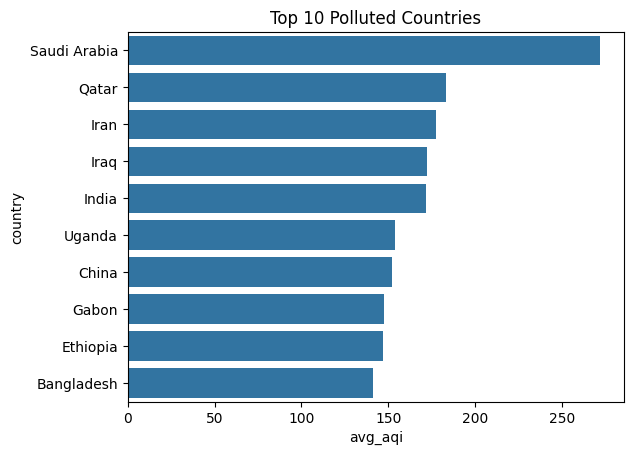

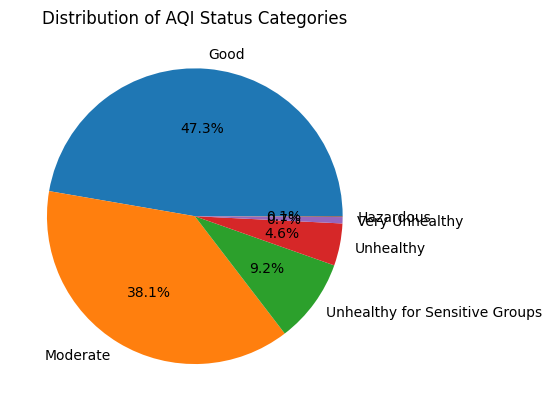

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 Polluted Countries
sns.barplot(data=df_avg.head(10), x="avg_aqi", y="country")
plt.title("Top 10 Polluted Countries")
plt.show()

# AQI Status Pie Chart
df_status.set_index("status").plot.pie(y="count", autopct="%.1f%%", legend=False)
plt.title("Distribution of AQI Status Categories")
plt.ylabel("")
plt.show()

# # AQI Trend Over Time
# plt.figure(figsize=(12,5))
# sns.lineplot(data=df_trend, x="data_date", y="daily_avg")
# plt.title("Global AQI Trend Over Time")
# plt.xlabel("Date")
# plt.ylabel("Average AQI")
# plt.xticks(rotation=45)
# plt.show()


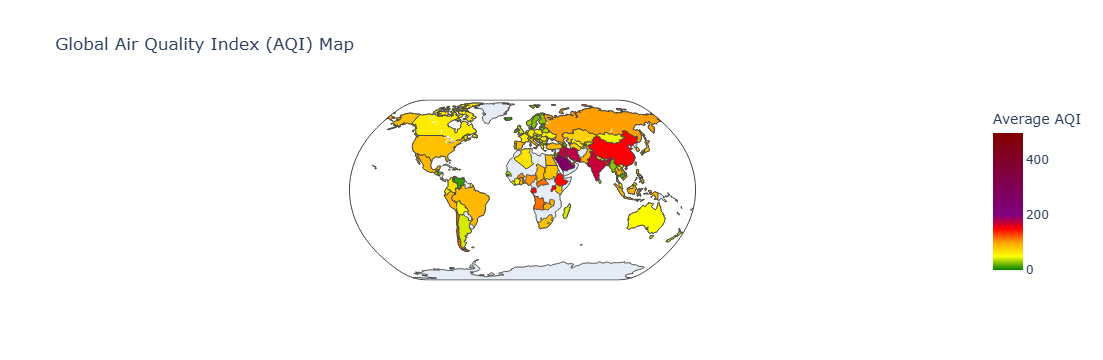

In [27]:
import plotly.express as px

# Sample: df_avg must have "country" and "avg_aqi"
fig = px.choropleth(
    df_avg,
    locations="country",
    locationmode="country names",
    color="avg_aqi",
    color_continuous_scale=[
        (0.00, "green"),      # Good
        (0.10, "yellow"),     # Moderate
        (0.20, "orange"),     # Unhealthy for sensitive groups
        (0.30, "red"),        # Unhealthy
        (0.40, "purple"),     # Very unhealthy
        (1.00, "maroon")      # Hazardous
    ],
    range_color=(0, 500),
    labels={'avg_aqi': 'Average AQI'},
    title="Global Air Quality Index (AQI) Map"
)

fig.update_geos(showcoastlines=True, projection_type="natural earth")
fig.show()


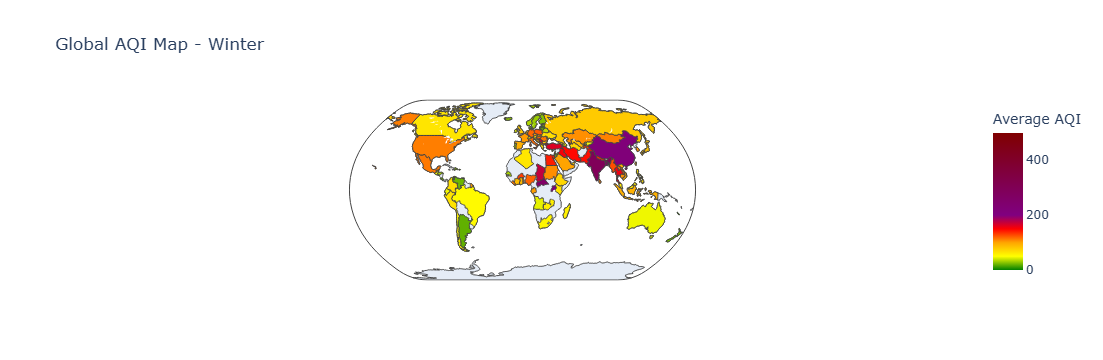

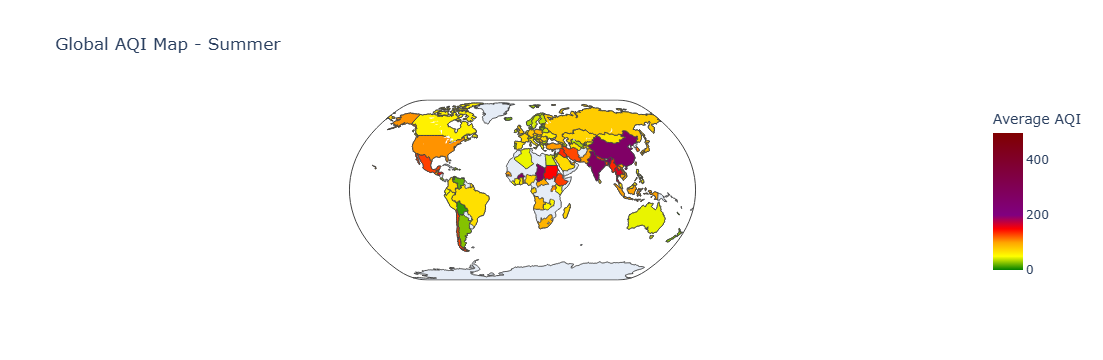

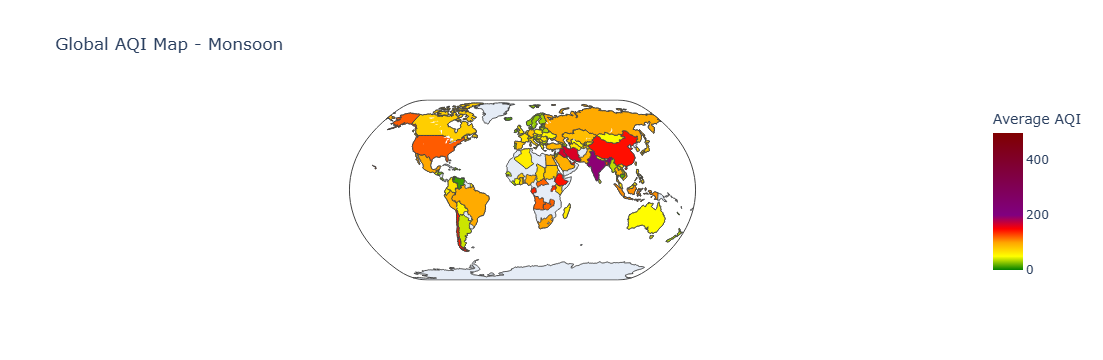

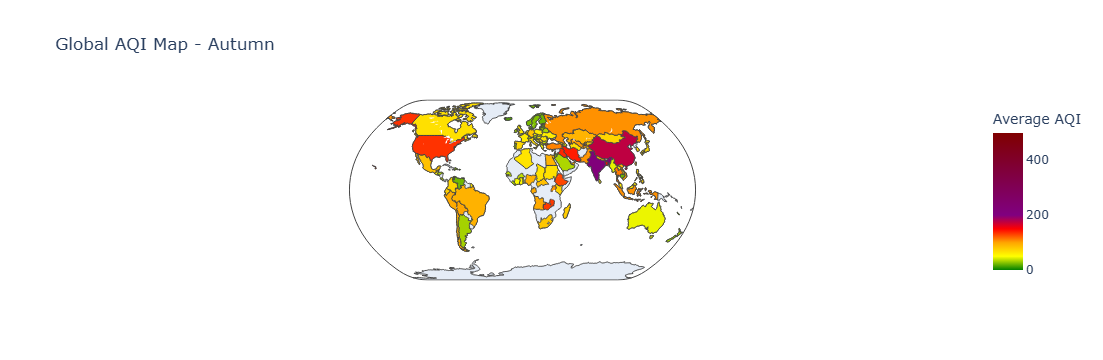

Season with highest average AQI globally:
     Season    avg_aqi
3   Winter  78.282565
2   Summer  68.208225
1  Monsoon  61.787735
0   Autumn  60.767514


In [28]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Step 2: Define function to assign seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Autumn'

# Step 3: Add Season column
df['Season'] = df['Date'].dt.month.apply(get_season)

# Step 4: Group by Country and Season to compute average AQI
df_grouped = df.groupby(['Country', 'Season'])['AQI Value'].mean().reset_index()
df_grouped.rename(columns={'AQI Value': 'avg_aqi'}, inplace=True)

# Step 5: Loop through seasons and generate a map per season
for season in ['Winter', 'Summer', 'Monsoon', 'Autumn']:
    df_season = df_grouped[df_grouped['Season'] == season]

    fig = px.choropleth(
        df_season,
        locations="Country",
        locationmode="country names",
        color="avg_aqi",
        color_continuous_scale=[
            (0.00, "green"),
            (0.10, "yellow"),
            (0.20, "orange"),
            (0.30, "red"),
            (0.40, "purple"),
            (1.00, "maroon")
        ],
        range_color=(0, 500),
        labels={'avg_aqi': 'Average AQI'},
        title=f"Global AQI Map - {season}"
    )

    fig.update_geos(showcoastlines=True, projection_type="natural earth")
    fig.show()

# Step 6: Optional - Show which season has highest average AQI globally
season_avg = df_grouped.groupby("Season")["avg_aqi"].mean().reset_index().sort_values("avg_aqi", ascending=False)
print("Season with highest average AQI globally:\n", season_avg)

In [29]:
season_counts = df['Season'].value_counts().reset_index()
season_counts.columns = ['Season', 'Sample Count']
print(season_counts)


    Season  Sample Count
0  Monsoon         10743
1   Autumn          4825
2   Summer          2655
3   Winter          1725


In [30]:
country_season_counts = df.groupby(['Country', 'Season']).size().reset_index(name='Sample Count')
print(country_season_counts)


     Country   Season  Sample Count
0    Albania   Autumn            36
1    Albania  Monsoon            78
2    Albania   Summer            22
3    Albania   Winter            12
4    Algeria   Autumn            33
..       ...      ...           ...
559  Vietnam   Winter            14
560   Zambia   Autumn            25
561   Zambia  Monsoon            74
562   Zambia   Summer             8
563   Zambia   Winter             1

[564 rows x 3 columns]


## Observations
- Country Saudi Arabia has the highest AQI
- Most data falls under "Good" status
- Highest AQI  in winter months

## 🔍 Extended Analysis: Industrial Emissions & Compliance

### 🏭 Zone Type Mapping (Urban/Industrial/Other)

In [31]:
# Step 1: Calculate average AQI per country
avg_aqi = df.groupby('Country')['AQI Value'].mean()

# Step 2: Define a function to assign zone type based on AQI
def classify_zone(aqi):
    if aqi >= 200:
        return 'Industrial'
    elif aqi >= 100:
        return 'Urban'
    else:
        return 'Clean/Rural'

# Step 3: Apply classification
zone_type_map = avg_aqi.apply(classify_zone)

# Step 4: Map the result to your main DataFrame
df['Zone_Type'] = df['Country'].map(zone_type_map)

# Optional: Check results
df[['Country', 'AQI Value', 'Zone_Type']].head()


,Country,AQI Value,Zone_Type
0,Albania,14,Clean/Rural
1,Algeria,65,Clean/Rural
2,Andorra,55,Clean/Rural
3,Angola,113,Urban
4,Argentina,63,Clean/Rural


### 📈 AQI Violation Rate by Country

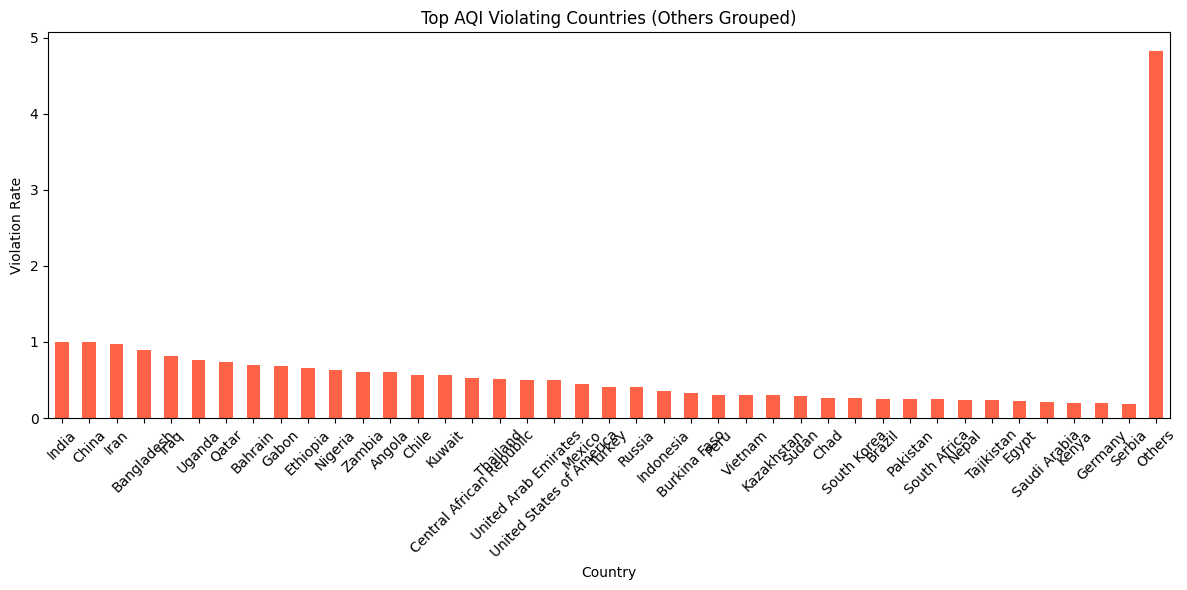

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Strip column names to remove trailing spaces
df.columns = df.columns.str.strip()

# Set threshold for AQI violation
violation_limit = 100

# Create violation indicator
df['is_violation'] = df['AQI Value'] > violation_limit

# Calculate violation rate per country
violation_summary = df.groupby('Country')['is_violation'].mean()

# Sort by violation rate descending
violation_summary_sorted = violation_summary.sort_values(ascending=False)

# --- Group smallest violators into "Others" ---
# Set number of countries to show (e.g., top 10 violators)
top_n = 40
# 
# Separate top countries and others
top_violators = violation_summary_sorted.head(top_n)
others_sum = violation_summary_sorted.iloc[top_n:].sum()

# Create new Series including "Others"
violation_summary_grouped = top_violators.copy()
violation_summary_grouped['Others'] = others_sum

# --- Plot ---
violation_summary_grouped.plot(
    kind='bar',
    figsize=(12, 6),
    color='tomato',
    title='Top AQI Violating Countries (Others Grouped)'
)
plt.ylabel('Violation Rate')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 🌐 AQI Heatmap by Country

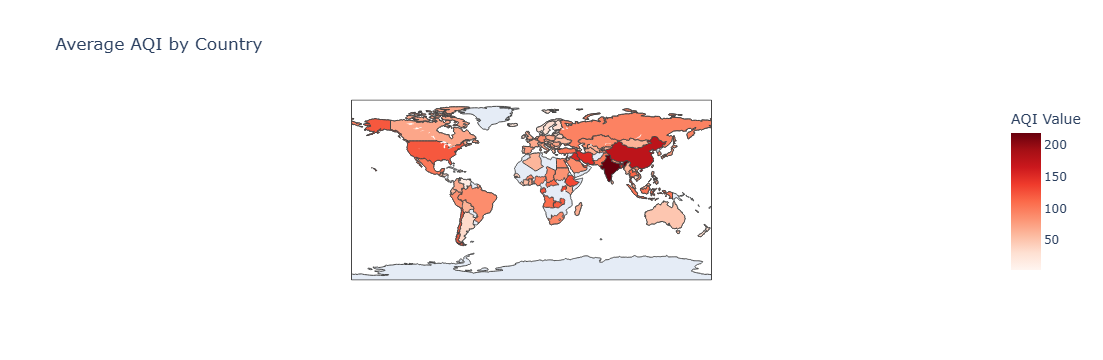

In [15]:
import plotly.express as px

country_avg = df.groupby("Country")["AQI Value"].mean().reset_index()
fig = px.choropleth(country_avg, locations="Country", locationmode="country names",
                    color="AQI Value", color_continuous_scale="Reds",
                    title="Average AQI by Country")
fig.show()

### 📊 Monthly AQI Trend

<Axes: title={'center': 'Monthly Average AQI Trend'}, xlabel='Date'>

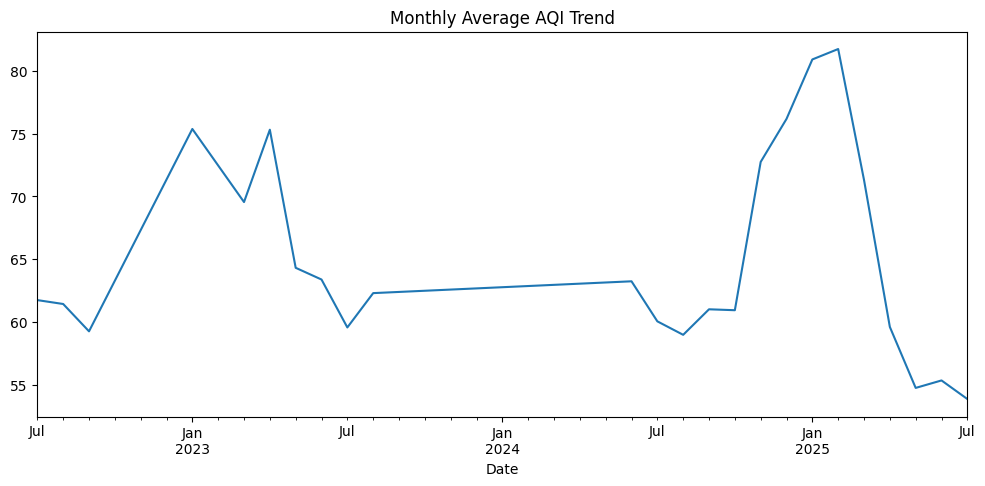

In [16]:
df['Date'] = pd.to_datetime(df['Date'])
monthly_avg = df.groupby(df['Date'].dt.to_period('M'))['AQI Value'].mean()
monthly_avg.plot(title='Monthly Average AQI Trend', figsize=(12, 5))

### ✅ Regulatory Compliance Table

In [46]:
# # STEP 1: Calculate compliance / violation percentage
# df['is_violation'] = df['AQI Value'] > 100  # Modify limit as per CPCB

# violation_summary = df.groupby('Country')['is_violation'].mean()

# # STEP 2: Define threshold (e.g., < 1% of all violations)
# threshold = 0.01

# # STEP 3: Split major and minor violators
# major = violation_summary[violation_summary >= threshold]
# minor = violation_summary[violation_summary < threshold]

# # STEP 4: Combine minor violators into 'Others'
# violation_summary_grouped = major.copy()
# violation_summary_grouped['Others'] = minor.sum()

# # STEP 5: Plot
# violation_summary_grouped.sort_values(ascending=False).plot(
#     kind='bar',
#     title='Regulatory Violation Rate by Country (Grouped)',
#     figsize=(12, 6),
#     color='orange'
# )


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets

# Ensure date column is datetime
df['date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.to_period('M').astype(str)

# Dropdown options
countries = df['Country'].dropna().unique().tolist()

# Main function to analyze selected country
def analyze_country(selected_country):
    df_country = df[df['Country'] == selected_country]

    if df_country.empty:
        print("No data available for this country.")
        return

    # Monthly average AQI
    df_monthly = df_country.groupby('month')['AQI Value'].mean().reset_index()

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df_monthly, x='month', y='AQI Value', marker='o', color='orange')
    plt.title(f"📈 Monthly AQI Trend - {selected_country}")
    plt.xlabel("Month")
    plt.ylabel("Average AQI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Summary insights
    avg_aqi = df_country['AQI Value'].mean()
    best = df_monthly.loc[df_monthly['AQI Value'].idxmin()]
    worst = df_monthly.loc[df_monthly['AQI Value'].idxmax()]

    print(f"✅ Average AQI in {selected_country}: {avg_aqi:.2f}")
    print(f"🟢 Best Air Quality Month: {best['month']} with AQI {best['AQI Value']:.2f}")
    print(f"🔴 Worst Air Quality Month: {worst['month']} with AQI {worst['AQI Value']:.2f}")

    
    # from numpy import polyfit, polyval
    # trend = polyfit(range(len(df)), df['AQI Value'], 1)
    # plt.plot(df['month'], polyval(trend, range(len(df))), 'r--', label='Trend')
    


In [68]:
interact(analyze_country, selected_country=widgets.Dropdown(options=countries, description="Country:"))



interactive(children=(Dropdown(description='Country:', options=('Albania', 'Algeria', 'Andorra', 'Angola', 'Ar…

<function __main__.analyze_country(selected_country)>